# Import libraries

In [39]:
import os
from helpers import parse_variables
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from helpers import parse_variables
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from helpers import parse_variables, get_risk_level, hi_gauss_blob_risk_fun, blob_risk_fun, NW_risk_fun, square_risk_fun, map_to_color, simulate_genos, calculate_true_maf_per_pop
from matplotlib.colors import LinearSegmentedColormap
import importlib.util
from models import ols_regression, manhattan_linear, gc

In [40]:
existing_risks = [
    "no_risk_fun",
    "NW_risk_fun",
    "N_risk_fun",
    "blob_risk_fun",
    "center_risk_fun",
    "big_square_risk_fun",
    "square_risk_fun",
    "hi_square_risk_fun",
    "mid_square_risk_fun",
    "mid_mid_square_risk_fun",
    "mid_mid_mid_square_risk_fun",
    "big_bad_square_risk_fun",
    "big_square_risk_fun_updated",
    "big_big_square_risk_fun",
    "big_big_big_square_risk_fun",
    "two_square_risk_fun",
    "three_square_risk_fun",
    "four_square_risk_fun",
    "as_big_blob_risk_fun",
    "six_square_risk_fun",
    "gauss_blob_risk_fun",
    "hi_gauss_blob_risk_fun"
]

In [41]:
risk = "two_square_risk_fun"

In [42]:
dict = parse_variables('geno_simulation.txt')
G = 10
L = 100
c = 50
k = 4
M = .1
HWE = 1

very_rare_to_save, rare_to_save, common_to_save, complete = simulate_genos(G, L, c, k, M, HWE)

In [43]:
humans = pd.DataFrame()
number_of_populations = k*k
labels_pop = []
for i in range(number_of_populations):
    labels_pop += [i+1]*c

humans["populations"] = labels_pop

In [44]:
true_p2s, true_twopqs, true_q2s = calculate_true_maf_per_pop(complete, humans)

In [45]:
number_of_individuals = c*k*k

In [46]:
count_total_AFs = complete.apply(pd.Series.value_counts).fillna(0)/number_of_individuals

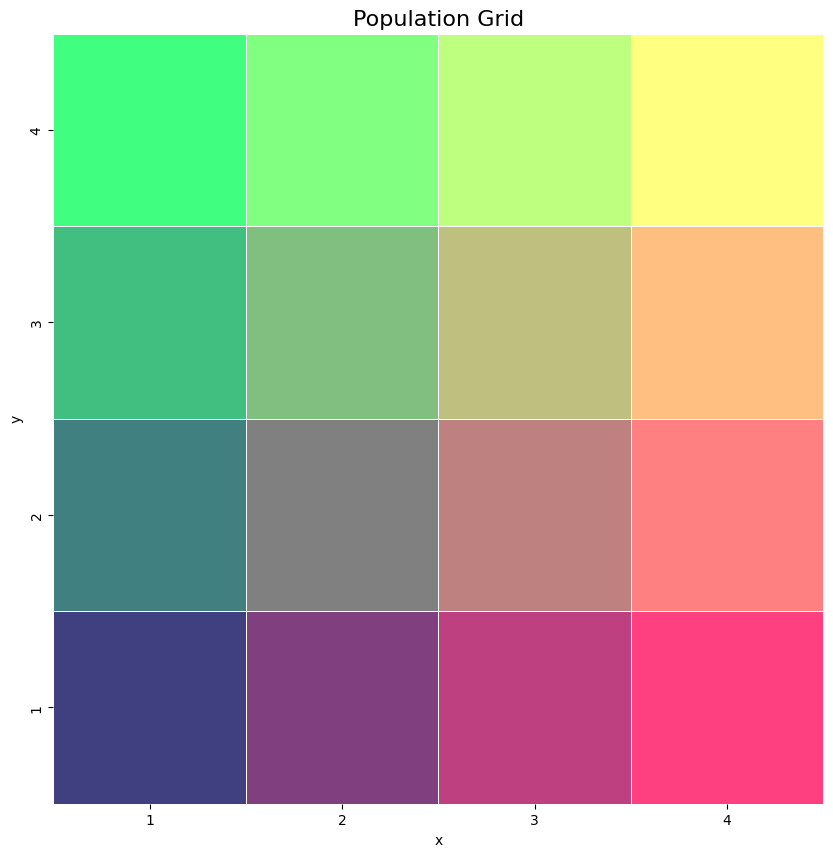

In [47]:
number_of_populations = k*k
labels_pop = []
for i in range(number_of_populations):
    labels_pop += [f"pop {i+1}"]*c
populations = pd.DataFrame(labels_pop, columns=['populations'])

populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
# Calculating X and Y coordinates
populations['x'] = ((populations['population_number'] - 1) % k) + 1
populations['y'] = ((populations['population_number'] - 1) // k) + 1
populations['z'] = 0.5
populations['population'] = populations['population_number']/(k*k)

palette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]
# Check the grid
df_agg = populations.groupby(['x', 'y']).agg({'population': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='population')

# Use seaborn to create the heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()
plt.close()

In [48]:
scaler = StandardScaler()
scaled_complete = scaler.fit_transform(complete)
n_components = max(min(complete.shape[1], 50), 4)
pca = PCA(n_components=n_components)
pc_labels_complete = [f"PC{i}" for i in range(1, n_components + 1)]
PC_complete = pca.fit_transform(scaled_complete)
PC_complete = pd.DataFrame(data=PC_complete, columns=pc_labels_complete)

In [49]:
to_have_collumns = ['populations', 'x', 'y']
PC_complete[to_have_collumns] = populations[to_have_collumns]

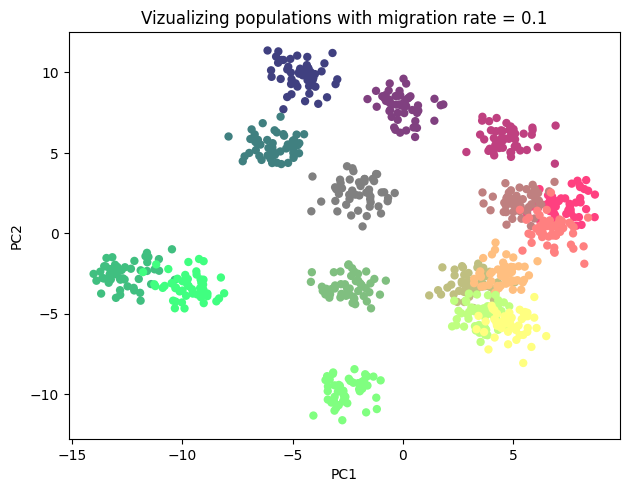

In [50]:
sns.scatterplot(x='PC1', y='PC2', data=PC_complete, color=palette, linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing populations with migration rate = {M}")
plt.show()
plt.close()

In [51]:
correction = pd.DataFrame()
for col in complete.columns:
    snp = complete[[col]]
    snp = pd.get_dummies(snp, columns=[col], dtype=int)
    correction[col] = list(complete[col]/(snp[f"{col}_-1.0"]*true_q2s[col] + snp[f"{col}_1.0"]*true_p2s[col] + snp[f"{col}_0.0"]*true_twopqs[col]))

In [52]:
correction

,CG1_AF_0.285,CG2_AF_0.268125,CG3_AF_0.291875,CG12_AF_0.331875,CG13_AF_0.27125,CG16_AF_0.30625,CG20_AF_0.20625,CG21_AF_0.22,CG24_AF_0.32375,CG25_AF_0.221875,...,VRG281_AF_0.035,VRG288_AF_0.02875,VRG304_AF_0.039375,VRG319_AF_0.041875,VRG392_AF_0.03625,VRG440_AF_0.035,VRG442_AF_0.035,VRG446_AF_0.039375,VRG484_AF_0.036875,VRG489_AF_0.03625
0,0.000000,1.041667,1.000000,0.000000,4.166667,1.111111,1.041667,-6.250000,1.000000,0.000000,...,1.041667,1.041667,0.000000,1.020408,1.111111,1.063830,1.086957,1.041667,1.020408,1.111111
1,0.000000,1.041667,1.000000,-4.166667,4.166667,1.111111,1.041667,2.777778,1.000000,0.000000,...,1.041667,1.041667,1.086957,1.020408,1.111111,1.063830,1.086957,1.041667,1.020408,1.111111
2,-4.166667,1.041667,1.000000,3.125000,0.000000,1.111111,1.041667,2.777778,1.000000,0.000000,...,1.041667,1.041667,1.086957,1.020408,1.111111,1.063830,1.086957,1.041667,1.020408,1.111111
3,-4.166667,1.041667,1.000000,-4.166667,4.166667,1.111111,1.041667,0.000000,1.000000,0.000000,...,1.041667,1.041667,1.086957,1.020408,1.111111,1.063830,1.086957,1.041667,1.020408,1.111111
4,0.000000,1.041667,1.000000,0.000000,0.000000,1.111111,1.041667,0.000000,1.000000,-4.166667,...,1.041667,1.041667,1.086957,1.020408,1.111111,1.063830,1.086957,1.041667,1.020408,1.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,1.162791,1.315789,2.941176,0.000000,0.000000,1.063830,0.000000,0.000000,0.000000,0.000000,...,1.020408,1.020408,1.111111,1.282051,1.041667,1.020408,1.063830,1.063830,1.190476,1.388889
796,1.162791,1.315789,0.000000,0.000000,0.000000,1.063830,0.000000,0.000000,0.000000,2.272727,...,1.020408,1.020408,1.111111,1.282051,1.041667,1.020408,1.063830,1.063830,1.190476,1.388889
797,1.162791,1.315789,0.000000,0.000000,0.000000,1.063830,2.272727,-4.166667,-3.333333,0.000000,...,1.020408,1.020408,0.000000,1.282051,1.041667,1.020408,1.063830,1.063830,1.190476,1.388889
798,1.162791,1.315789,0.000000,0.000000,2.173913,1.063830,0.000000,-4.166667,-3.333333,2.272727,...,1.020408,1.020408,1.111111,1.282051,1.041667,1.020408,1.063830,1.063830,1.190476,1.388889


In [53]:

# Check if any column contains NaN values
nan_columns = correction.isna().any()

# Check if any column contains inf values (both positive and negative inf)
inf_columns = correction.isin([np.inf, -np.inf]).any()

# Combine NaN and inf column checks into one dataframe for easier viewing
nan_inf_summary = pd.DataFrame({
    'NaN': nan_columns,
    'inf': inf_columns
})

# Show the columns that contain NaN or inf values
nan_inf_summary[nan_inf_summary['NaN'] | nan_inf_summary['inf']]

,NaN,inf


In [54]:
# Replace inf values (-inf and inf) with NaN first (to handle both at once)
correction.replace([np.inf, -np.inf], np.nan, inplace=True)

# Now fill NaN values with the corresponding values from the 'complete' dataframe
correction.fillna(complete, inplace=True)


In [55]:
# calibrating
for col in correction.columns:
    X = correction[[col]]
    y = complete[col]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[col]
    #correction[col] = correction[col]*beta

In [56]:
correction

,CG1_AF_0.285,CG2_AF_0.268125,CG3_AF_0.291875,CG12_AF_0.331875,CG13_AF_0.27125,CG16_AF_0.30625,CG20_AF_0.20625,CG21_AF_0.22,CG24_AF_0.32375,CG25_AF_0.221875,...,VRG281_AF_0.035,VRG288_AF_0.02875,VRG304_AF_0.039375,VRG319_AF_0.041875,VRG392_AF_0.03625,VRG440_AF_0.035,VRG442_AF_0.035,VRG446_AF_0.039375,VRG484_AF_0.036875,VRG489_AF_0.03625
0,0.000000,1.041667,1.000000,0.000000,4.166667,1.111111,1.041667,-6.250000,1.000000,0.000000,...,1.041667,1.041667,0.000000,1.020408,1.111111,1.063830,1.086957,1.041667,1.020408,1.111111
1,0.000000,1.041667,1.000000,-4.166667,4.166667,1.111111,1.041667,2.777778,1.000000,0.000000,...,1.041667,1.041667,1.086957,1.020408,1.111111,1.063830,1.086957,1.041667,1.020408,1.111111
2,-4.166667,1.041667,1.000000,3.125000,0.000000,1.111111,1.041667,2.777778,1.000000,0.000000,...,1.041667,1.041667,1.086957,1.020408,1.111111,1.063830,1.086957,1.041667,1.020408,1.111111
3,-4.166667,1.041667,1.000000,-4.166667,4.166667,1.111111,1.041667,0.000000,1.000000,0.000000,...,1.041667,1.041667,1.086957,1.020408,1.111111,1.063830,1.086957,1.041667,1.020408,1.111111
4,0.000000,1.041667,1.000000,0.000000,0.000000,1.111111,1.041667,0.000000,1.000000,-4.166667,...,1.041667,1.041667,1.086957,1.020408,1.111111,1.063830,1.086957,1.041667,1.020408,1.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,1.162791,1.315789,2.941176,0.000000,0.000000,1.063830,0.000000,0.000000,0.000000,0.000000,...,1.020408,1.020408,1.111111,1.282051,1.041667,1.020408,1.063830,1.063830,1.190476,1.388889
796,1.162791,1.315789,0.000000,0.000000,0.000000,1.063830,0.000000,0.000000,0.000000,2.272727,...,1.020408,1.020408,1.111111,1.282051,1.041667,1.020408,1.063830,1.063830,1.190476,1.388889
797,1.162791,1.315789,0.000000,0.000000,0.000000,1.063830,2.272727,-4.166667,-3.333333,0.000000,...,1.020408,1.020408,0.000000,1.282051,1.041667,1.020408,1.063830,1.063830,1.190476,1.388889
798,1.162791,1.315789,0.000000,0.000000,2.173913,1.063830,0.000000,-4.166667,-3.333333,2.272727,...,1.020408,1.020408,1.111111,1.282051,1.041667,1.020408,1.063830,1.063830,1.190476,1.388889


In [57]:
complete

snps,CG1_AF_0.285,CG2_AF_0.268125,CG3_AF_0.291875,CG12_AF_0.331875,CG13_AF_0.27125,CG16_AF_0.30625,CG20_AF_0.20625,CG21_AF_0.22,CG24_AF_0.32375,CG25_AF_0.221875,...,VRG281_AF_0.035,VRG288_AF_0.02875,VRG304_AF_0.039375,VRG319_AF_0.041875,VRG392_AF_0.03625,VRG440_AF_0.035,VRG442_AF_0.035,VRG446_AF_0.039375,VRG484_AF_0.036875,VRG489_AF_0.03625
0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,-1.0,1.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,-1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
796,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
797,1.0,1.0,0.0,0.0,0.0,1.0,1.0,-1.0,-1.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
798,1.0,1.0,0.0,0.0,1.0,1.0,0.0,-1.0,-1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# Risk

In [58]:
# Dynamically import the function based on the risk level
module_name = 'helpers'
module_spec = importlib.util.spec_from_file_location(module_name, 'helpers.py')
helpers = importlib.util.module_from_spec(module_spec)
module_spec.loader.exec_module(helpers)

In [59]:
risk_function = getattr(helpers, risk)
name_risk = risk.split('_fun')[0]
populations['x_temp'] = populations['x']/k
populations['y_temp'] = populations['y']/k
populations[name_risk] = list(populations.apply(lambda row: risk_function(row['x_temp'], row['y_temp']), axis=1))
populations[name_risk] = populations[name_risk].astype('float')

<Axes: xlabel='x', ylabel='y'>

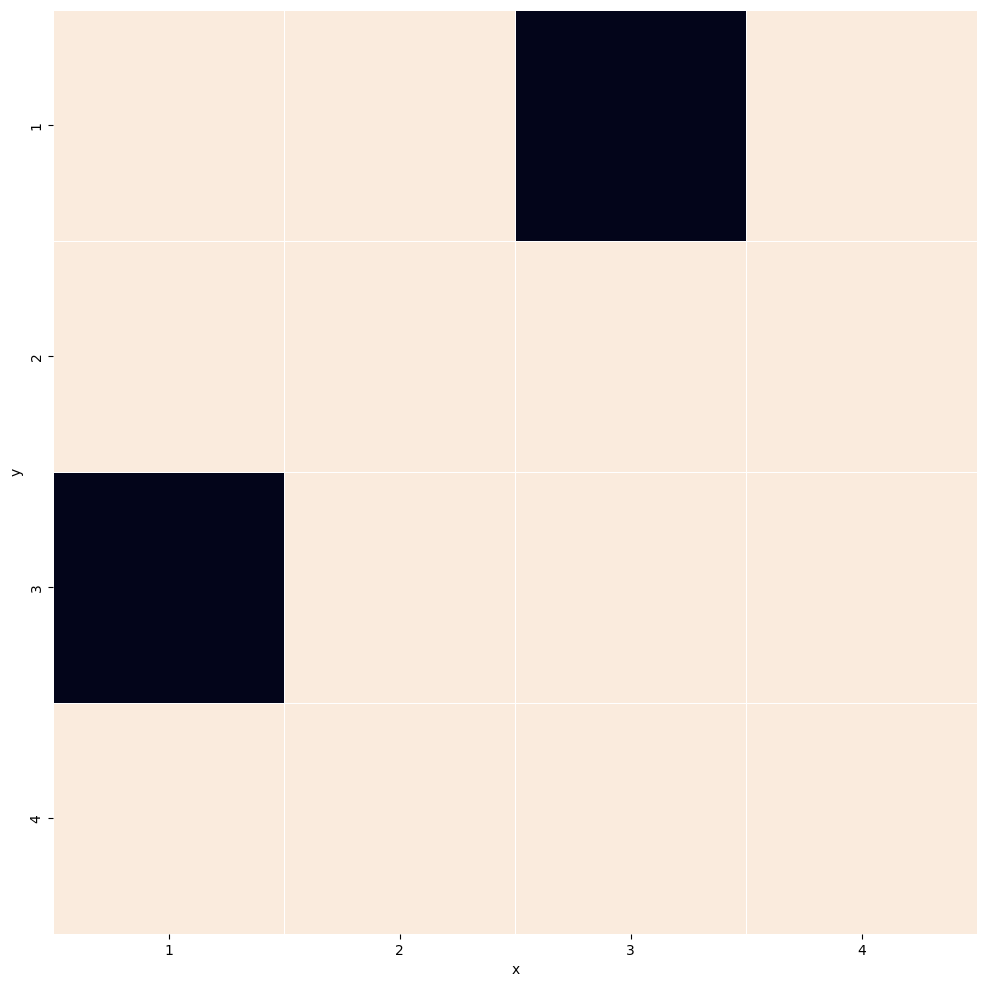

In [60]:
# Create subplots for each risk
fig, axs = plt.subplots(1, 1, figsize=(14, 12))
# Aggregate by x and y and calculate mean for each risk
df_agg = populations.groupby(['x', 'y']).agg({name_risk: 'mean'}).reset_index()
grid_df = df_agg.pivot(index='y', columns='x', values=name_risk)
sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)

In [61]:
name_risk

'two_square_risk'

In [62]:
PC_complete['risk'] = populations[name_risk]
humans['risk'] = populations[name_risk]

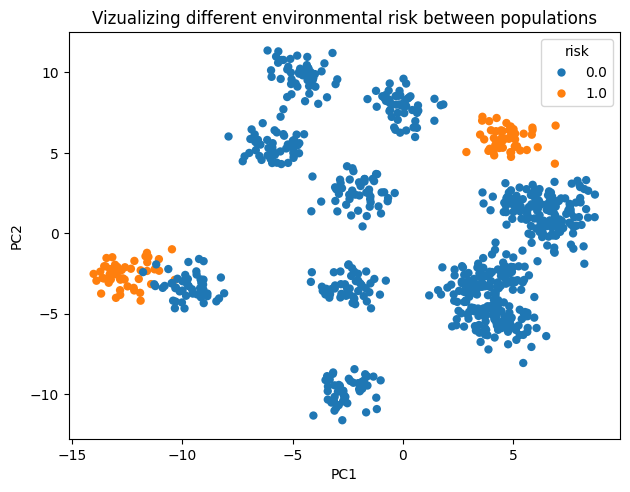

In [63]:
sns.scatterplot(x='PC1', y='PC2', data=PC_complete, hue = 'risk', linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing different environmental risk between populations")
plt.show()
plt.close()

# check for one

In [64]:
to_check = list(complete.columns)[6]

In [65]:
humans = pd.DataFrame()
humans['snp'] = complete[to_check]
humans['pop'] = PC_complete['populations']
humans['risk'] = PC_complete['risk']

In [66]:
X = humans[['snp']]  # Predictor variable
y = humans['risk']    # Response variable

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['snp']
print(beta)
intercept = model.params['const']
p_value = model.pvalues['snp']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

-0.06446601941747568


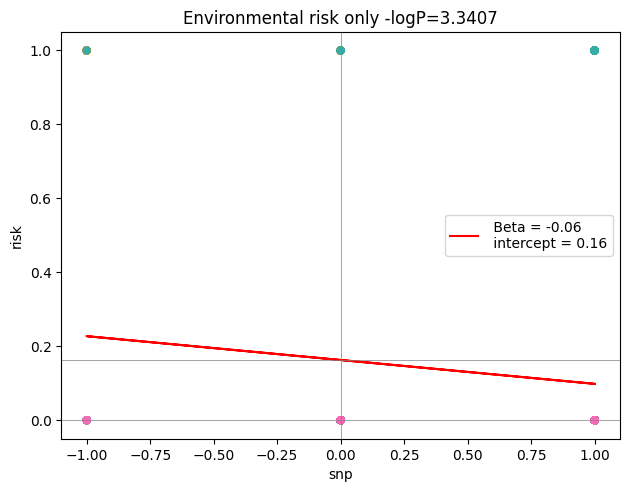

In [67]:
# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='snp', y='risk', data=humans, hue='pop', linewidth=0, legend=False)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['snp'], humans['predicted_risk'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}')

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

In [68]:
humans['corr'] = correction[to_check]

In [69]:
X = humans[['corr']]  # Predictor variable
y = humans['risk']    # Response variable

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['corr']
print(beta)
intercept = model.params['const']
p_value = model.pvalues['corr']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

-0.0032383669223109554


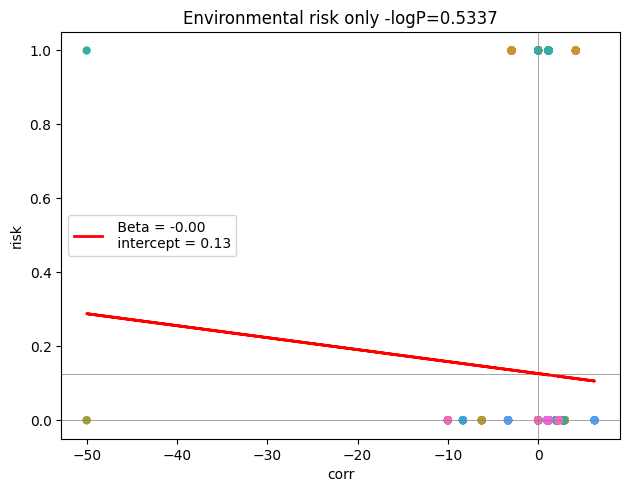

In [70]:
# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='corr', y='risk', data=humans, hue='pop', linewidth=0, legend=False)

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['corr'], humans['predicted_risk'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}', linewidth=2)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

In [71]:
# p2 min q2

In [73]:
pminq = true_p2s - true_q2s

In [76]:
humans['pminq'] = pminq[to_check]

In [77]:
X = humans[['pminq']]  # Predictor variable
y = humans['risk']    # Response variable

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['pminq']
print(beta)
intercept = model.params['const']
p_value = model.pvalues['pminq']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

-0.1688158483504862


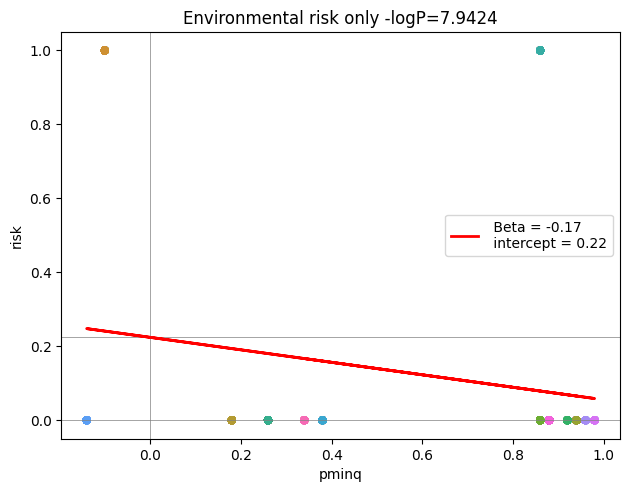

In [79]:
# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='pminq', y='risk', data=humans, hue='pop', linewidth=0, legend=False)

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['pminq'], humans['predicted_risk'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}', linewidth=2)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

In [81]:
X = humans[['pminq']]  # Predictor variable
y = humans['snp']    # Response variable

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['pminq']
print(beta)
intercept = model.params['const']
p_value = model.pvalues['pminq']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

0.9999999999999994


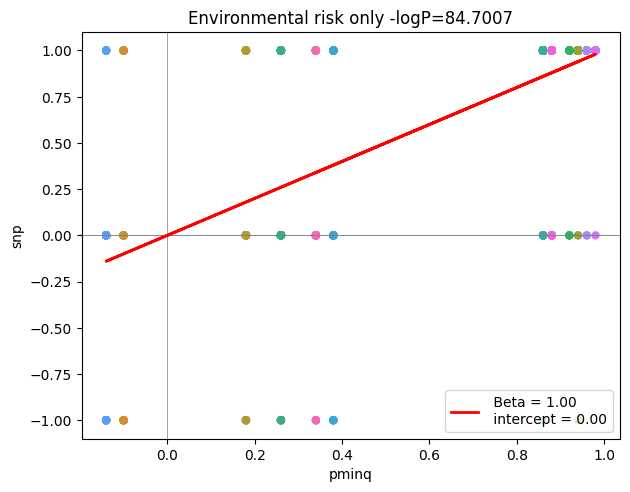

In [82]:
# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='pminq', y='snp', data=humans, hue='pop', linewidth=0, legend=False)

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['pminq'], humans['predicted_risk'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}', linewidth=2)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

# Manually comparing the betas

In [83]:
y = humans['risk']
betas_snps = []
betas_mafs_ols = []
intercept_snps = []
intercept_mafs = []

logP_snps = []
logP_mafs_ols = []

In [84]:
for snp in complete.columns:
    beta_snps = manhattan_linear(complete[[snp]], y)
    beta_mafs_ols = manhattan_linear(correction[[f"{snp}"]], y)

    betas_snps.append(beta_snps['coefs'][0])
    logP_snps.append(beta_snps['-logPs'][0])

    betas_mafs_ols.append(beta_mafs_ols['coefs'][0])
    logP_mafs_ols.append(beta_mafs_ols['-logPs'][0])

In [85]:
to_compare = pd.DataFrame()
to_compare['beta_snp'] = betas_snps
to_compare['beta_maf'] = betas_mafs_ols

to_compare['logP_snps'] = logP_snps
to_compare['logP_mafs_ols'] = logP_mafs_ols

In [86]:
to_compare

,beta_snp,beta_maf,logP_snps,logP_mafs_ols
0,1.950839e-02,1.015020e-03,6.330290e-01,9.152993e-02
1,-1.333917e-02,9.107298e-18,3.780170e-01,5.785965e-16
2,9.273255e-04,2.284846e-03,1.994918e-02,2.147566e-01
3,4.851903e-02,3.944354e-03,2.689341e+00,3.855878e-01
4,1.379564e-02,9.378797e-04,3.804678e-01,8.766999e-02
...,...,...,...,...
455,-1.479290e-01,2.349748e-03,3.007549e+00,1.460221e-01
456,3.018419e-16,2.352869e-03,2.314386e-15,1.461323e-01
457,-2.921561e-01,-3.059417e-02,1.176571e+01,3.342478e+00
458,2.267153e-02,-3.989120e-03,2.262291e-01,5.431973e-01


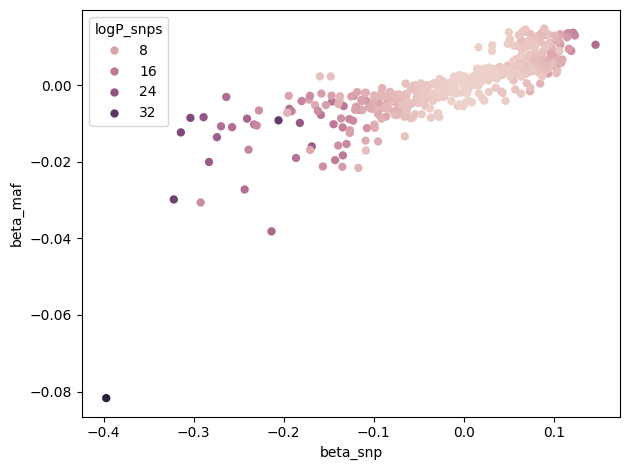

In [87]:
sns.scatterplot(x='beta_snp', y='beta_maf',data=to_compare, hue= 'logP_snps',linewidth=0)
# Adjust layout
plt.tight_layout()
plt.title(f"")
plt.show()
plt.close()

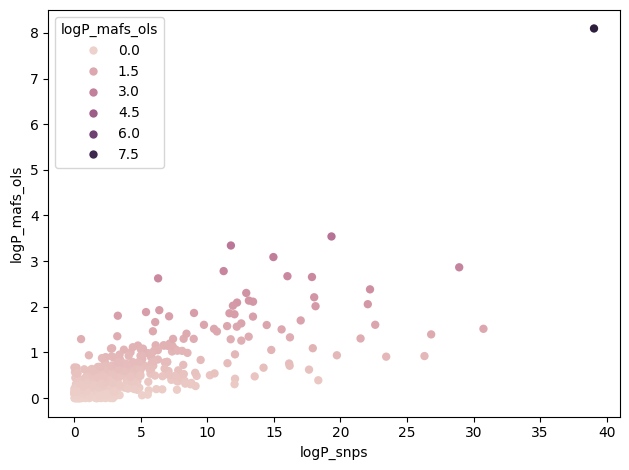

In [88]:
sns.scatterplot(x='logP_snps', y='logP_mafs_ols',data=to_compare, hue= 'logP_mafs_ols',linewidth=0)
# Adjust layout
plt.tight_layout()
plt.title(f"")
plt.show()
plt.close()

# with causal SNP

In [98]:
def divi(arr, effectsize):
    return [(1 / (num + 0.001)) * effectsize for num in arr]

def multi(arr, effectsize):
    return [num * effectsize for num in arr]

In [99]:
effectsize = 1
numbers_af = [float(col.split('_AF_')[1]) for col in complete.columns if '_AF_' in col]
snp_names = [col.split('_AF_')[0] for col in complete.columns if '_AF_' in col]

beta_values = divi(numbers_af, effectsize)
data = {'snp': snp_names, 'Beta': beta_values}
betas = pd.DataFrame(data)

In [100]:
all_snps = list(complete.columns)
phenos_mono = []
for snp in all_snps:
    index_snp = snp.split('_')[0]
    beta_value = betas.loc[betas['snp'] == index_snp, 'Beta'].values[0]
    phenos_mono.append(complete[snp] * beta_value)

# Converting phenos_mono list of series to DataFrame directly
phenos_mono = pd.concat(phenos_mono, axis=1)
phenos_mono.columns = complete.columns

# Add noise
n = len(phenos_mono)
for snp in list(phenos_mono.columns):
    var_effect = np.var(phenos_mono[snp])
    total_variance = var_effect / 0.01
    var_noise = total_variance - var_effect
    sd_noise = np.sqrt(var_noise)
    # Generate phenotype with noise
    phenos_mono[snp] = phenos_mono[snp] + np.random.normal(0, sd_noise, n)
    std_dev = np.std(phenos_mono[snp])
    mean = np.mean(phenos_mono[snp])
    phenos_mono[snp] = (phenos_mono[snp] - mean) / std_dev

In [101]:
y = humans['risk']
betas_snps = []
betas_mafs_ols = []
intercept_snps = []
intercept_mafs = []

logP_snps = []
logP_mafs_ols = []

In [102]:
for snp in complete.columns:
    beta_snps = manhattan_linear(complete[[snp]], phenos_mono[snp])
    beta_mafs_ols = manhattan_linear(correction[[f"{snp}"]], phenos_mono[snp])

    betas_snps.append(beta_snps['coefs'][0])
    logP_snps.append(beta_snps['-logPs'][0])

    betas_mafs_ols.append(beta_mafs_ols['coefs'][0])
    logP_mafs_ols.append(beta_mafs_ols['-logPs'][0])

In [103]:
to_compare = pd.DataFrame()
to_compare['beta_snp'] = betas_snps
to_compare['beta_maf'] = betas_mafs_ols

to_compare['logP_snps'] = logP_snps
to_compare['logP_mafs_ols'] = logP_mafs_ols

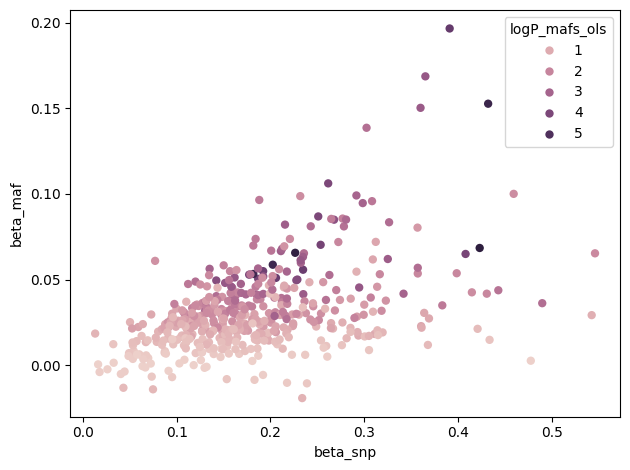

In [104]:
sns.scatterplot(x='beta_snp', y='beta_maf',data=to_compare, hue= 'logP_mafs_ols',linewidth=0)
# Adjust layout
plt.tight_layout()
plt.title(f"")
plt.show()
plt.close()

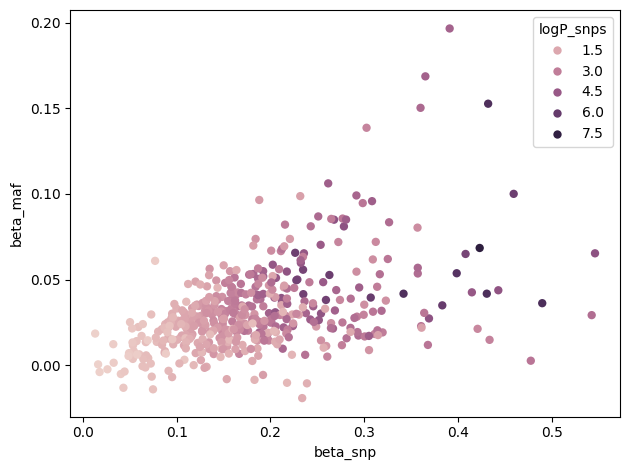

In [105]:
sns.scatterplot(x='beta_snp', y='beta_maf',data=to_compare, hue= 'logP_snps',linewidth=0)
# Adjust layout
plt.tight_layout()
plt.title(f"")
plt.show()
plt.close()

# Met causal snp

In [62]:
betas['Beta'] = betas['Beta']/betas['Beta'].max()

In [63]:
betas['Beta']

0      0.063032
1      0.074447
2      0.056748
3      0.041249
4      0.084668
         ...   
389    0.425287
390    1.000000
391    0.381443
392    0.596774
393    0.596774
Name: Beta, Length: 394, dtype: float64

In [67]:
all_snps = list(complete.columns)
phenos_mono = []
for snp in all_snps:
    index_snp = snp.split('_')[0]
    beta_value = betas.loc[betas['snp'] == index_snp, 'Beta'].values[0]
    phenos_mono.append(complete[snp] * beta_value)

# Converting phenos_mono list of series to DataFrame directly
phenos_mono = pd.concat(phenos_mono, axis=1)
phenos_mono.columns = complete.columns

# Add noise
n = len(phenos_mono)
for snp in list(phenos_mono.columns):
    var_effect = np.var(phenos_mono[snp])
    total_variance = var_effect / 1
    var_noise = total_variance - var_effect
    sd_noise = np.sqrt(var_noise)
    # Generate phenotype with noise
    phenos_mono[snp] = phenos_mono[snp] + np.random.normal(0, sd_noise, n)
    std_dev = np.std(phenos_mono[snp])
    mean = np.mean(phenos_mono[snp])
    phenos_mono[snp] = (phenos_mono[snp] - mean) / std_dev

In [68]:
humans['pheno'] = phenos_mono[snp]
PC_complete['pheno'] = phenos_mono[snp]

In [71]:
humans

,populations,risk,snp,pheno
0,1,1.0,1.0,0.232845
1,1,1.0,1.0,0.232845
2,1,1.0,1.0,0.232845
3,1,1.0,1.0,0.232845
4,1,1.0,1.0,0.232845
...,...,...,...,...
195,2,-1.0,1.0,0.232845
196,2,-1.0,1.0,0.232845
197,2,-1.0,1.0,0.232845
198,2,-1.0,1.0,0.232845


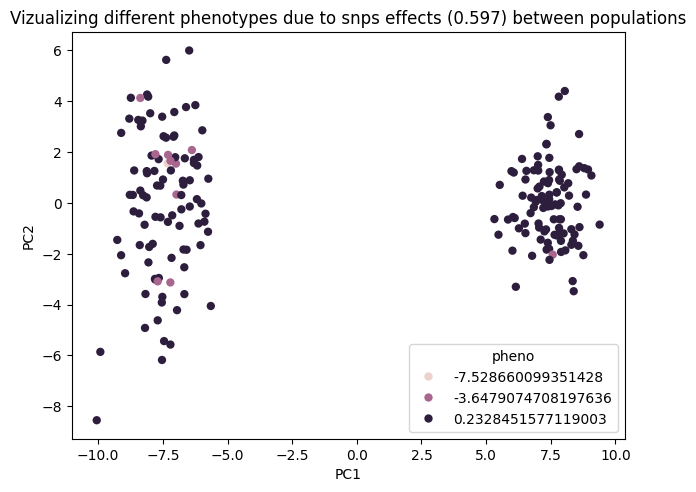

In [69]:
sns.scatterplot(x='PC1', y='PC2', data=PC_complete, hue = 'pheno', linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing different phenotypes due to snps effects ({np.round(beta_value,3)}) between populations")
plt.show()
plt.close()

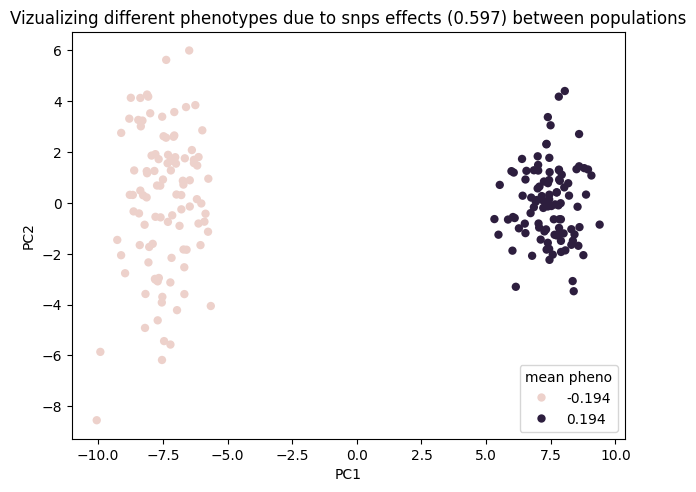

In [70]:
mean_snp_effect_per_pop = np.round(PC_complete.groupby('populations')['pheno'].transform('mean'),3)

# Add the calculated mean as a new column
PC_complete['mean pheno'] = mean_snp_effect_per_pop

sns.scatterplot(x='PC1', y='PC2', data=PC_complete, hue = 'mean pheno', linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing different phenotypes due to snps effects ({np.round(beta_value,3)}) between populations")
plt.show()
plt.close()

# Calculating betas

In [57]:
betas

,snp,Beta
0,CG3,0.4225
1,CG4,0.2925
2,CG5,0.4475
3,CG6,0.2275
4,CG7,0.4425
...,...,...
420,VRG147,0.0450
421,VRG184,0.0325
422,VRG198,0.0475
423,VRG371,0.0475


In [58]:
snp

'VRG423_AF_0.0275'

In [68]:
total_pop = len(complete)
val_minor = -1
val_het = 0
val_major = 1
betas_mafs_manually = []
betas_mafs_ols = []
logP_mafs_ols = []
betas_snps = []
logP_snps = []
true_betas = []
for snp in complete.columns:
    beta_value = betas.loc[betas['snp'] == snp.split('_AF_')[0], 'Beta'].values[0]
    true_betas.append(beta_value)
    humans['snp'] = complete[snp]
    humans['pheno'] = phenos_mono[snp]
    
    #humans['pheno'] = min_max_scaling(humans['pheno'],0,1)
    mean_risk_per_pop = {}
    nr_people_per_pop = {}
    maj_afs = {}
    min_afs = {}
    het_afs = {}
    total_nr_peeps = 0
    mean_global_risk = 0

    X_from_mafs = []
    Y_from_mafs = []
    for unique_pop in humans.populations.unique():
        temp = humans[humans['populations'] == unique_pop]
        nr_humans_pop = len(temp)
    
        total_alleles = len(temp['snp'])  # Total number of alleles (2 alleles per sample)
        q2_freq = (temp['snp'].value_counts().get(val_minor, 0))/total_alleles
        pq_freq = (temp['snp'].value_counts().get(val_het, 0))/total_alleles
        p2_freq = (temp['snp'].value_counts().get(val_major, 0))/total_alleles

        X = val_minor*q2_freq + val_het*pq_freq + val_major*p2_freq
        X_from_mafs.append(X*(nr_humans_pop**2/total_pop))
        Y_from_mafs.append(temp['pheno'].mean())

    X = min_max_scaling(X_from_mafs,-1,1)
    #X=np.array(X_from_mafs)
    Y = np.array(Y_from_mafs)
    
    n = len(X)
    sum_X = np.sum(X)
    sum_Y = np.sum(Y)
    sum_XY = np.sum(X * Y)
    sum_X_squared = np.sum(X**2)
    betas_mafs_manually.append((n * sum_XY - sum_X * sum_Y) / (n * sum_X_squared - sum_X**2))

    beta_snps = manhattan_linear(complete[[snp]], humans[['pheno']])
    beta_mafs_ols = manhattan_linear(maf_df[[snp]], humans[['pheno']])
    
    betas_snps.append(beta_snps['coefs'][0])
    logP_snps.append(beta_snps['-logPs'][0])

    betas_mafs_ols.append(beta_mafs_ols['coefs'][0])
    logP_mafs_ols.append(beta_mafs_ols['-logPs'][0])

IndexError: list index out of range

In [ ]:
to_compare = pd.DataFrame()
to_compare['beta_snp'] = betas_snps
to_compare['-logP_snp'] = logP_snps
to_compare['beta_maf_manual'] = betas_mafs_manually
to_compare['beta_maf_ols'] = betas_mafs_ols
to_compare['-logP_maf_ols'] = logP_mafs_ols
to_compare['true_betas'] = true_betas


In [ ]:
sns.scatterplot(x='true_betas', y='beta_snp',data=to_compare, linewidth=0)
# Adjust layout
plt.tight_layout()
plt.title(f"")
plt.show()
plt.close()

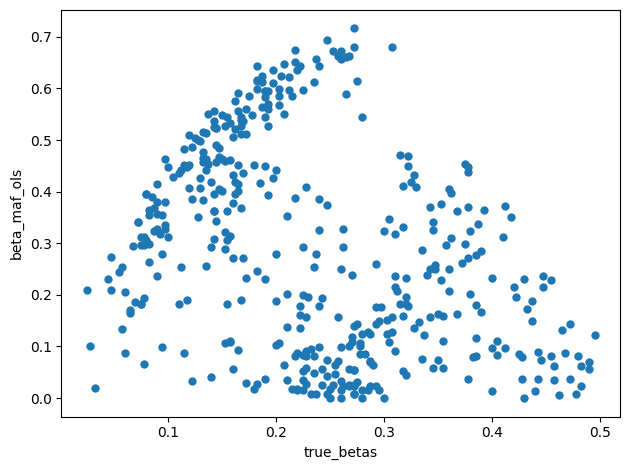

In [66]:
sns.scatterplot(x='true_betas', y='beta_maf_ols',data=to_compare, linewidth=0)
# Adjust layout
plt.tight_layout()
plt.title(f"")
plt.show()
plt.close()